In [1]:
# Imports

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.7.0


In [4]:
dataset_dir = '../dataset'

In [5]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
CHANNELS=3
EPOCHS=50

In [6]:
dataset = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                      shuffle = True,
                                                      batch_size = BATCH_SIZE,
                                                      image_size = IMAGE_SIZE)

Found 4000 files belonging to 4 classes.


In [7]:
# Exploring the dataset

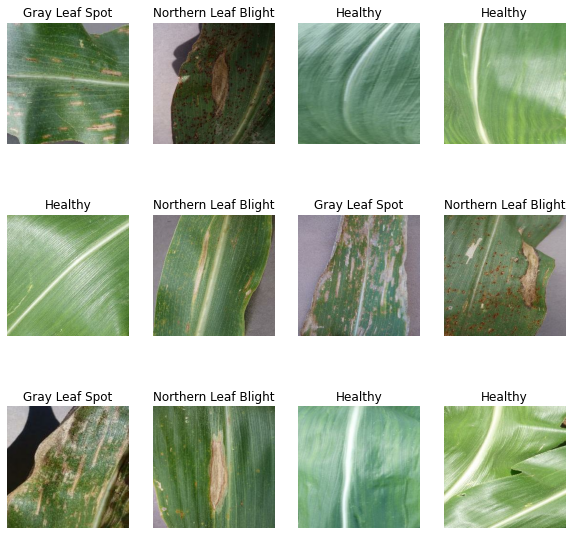

In [8]:
class_names = dataset.class_names

plt.figure(figsize=(10, 10))

for images, labels in dataset.take(1):
    
  for i in range(12):
    
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
print("Length of dataset is {}. Remember that batch size of images is 32. Total of images is 4000 = 125 x 32.".format(len(dataset)))

Length of dataset is 125. Remember that batch size of images is 32. Total of images is 4000 = 125 x 32.


In [10]:
# Training Dataset, Validation Dataset and Test Dataset

In [11]:
total_dataset_len = len(dataset)

In [12]:
# 80 % Training Dataset
# 20 % Validation Dataset & Test Dataset

In [13]:
training_dataset_len = int(total_dataset_len * 0.8)

training_dataset = dataset.take(training_dataset_len)
print(training_dataset_len)

100


In [14]:
# To be used for Validation & Testing
rest_of_dataset = dataset.skip(training_dataset_len)
rest_of_dataset_len = len(rest_of_dataset) 
print(rest_of_dataset_len)

25


In [15]:
validation_dataset_len = int(rest_of_dataset_len * 0.5)
validation_dataset = rest_of_dataset.take(validation_dataset_len)
validation_dataset_len

12

In [16]:
test_dataset = rest_of_dataset.skip(validation_dataset_len)
print(len(test_dataset))

13


In [17]:
# Cache, Shuffle, and Prefetch the dataset

In [18]:
def optimize(dataset):
    
    return dataset.cache().shuffle(100).prefetch(tf.data.AUTOTUNE)

training_dataset = optimize(training_dataset)
validation_dataset = optimize(validation_dataset)
test_dataset = optimize(test_dataset)

In [19]:
# Data augmentation

In [20]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

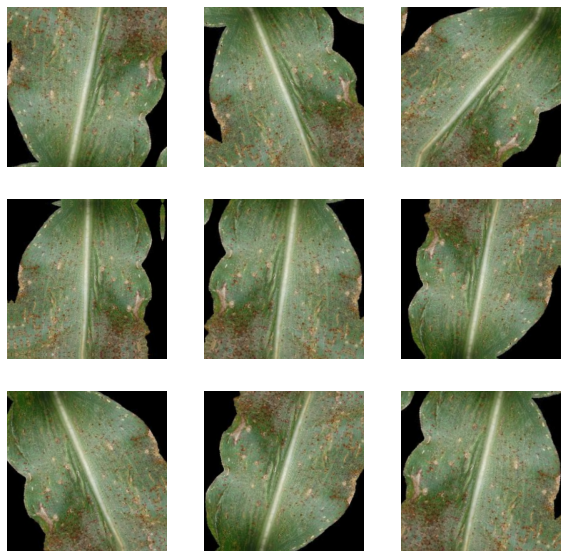

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in training_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
# Model architecture

In [23]:
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(class_names))
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)       

In [26]:
history = model.fit(
    training_dataset,
    batch_size = BATCH_SIZE,
    validation_data = validation_dataset,
    verbose = 1,
    epochs = 50
)

Epoch 1/50
100/100 [==============================] - 73s 719ms/step - loss: 0.6411 - accuracy: 0.7350 - val_loss: 0.3093 - val_accuracy: 0.8646
Epoch 2/50
100/100 [==============================] - 70s 705ms/step - loss: 0.3187 - accuracy: 0.8450 - val_loss: 0.3008 - val_accuracy: 0.8594
Epoch 3/50
100/100 [==============================] - 70s 704ms/step - loss: 0.2771 - accuracy: 0.8737 - val_loss: 0.2527 - val_accuracy: 0.8568
Epoch 4/50
100/100 [==============================] - 74s 743ms/step - loss: 0.2413 - accuracy: 0.8897 - val_loss: 0.1788 - val_accuracy: 0.9167
Epoch 5/50
100/100 [==============================] - 80s 803ms/step - loss: 0.2581 - accuracy: 0.8900 - val_loss: 0.2148 - val_accuracy: 0.9062
Epoch 6/50
100/100 [==============================] - 77s 771ms/step - loss: 0.2262 - accuracy: 0.9094 - val_loss: 0.2332 - val_accuracy: 0.8958
Epoch 7/50
100/100 [==============================] - 73s 727ms/step - loss: 0.2293 - accuracy: 0.8975 - val_loss: 0.2196 - val_ac

In [27]:
scores = model.evaluate(test_dataset)
scores

13/13 [==============================] - 4s 159ms/step - loss: 0.1065 - accuracy: 0.9712


[0.10649354755878448, 0.9711538553237915]

In [28]:
# Plotting the loss and accuracy curves

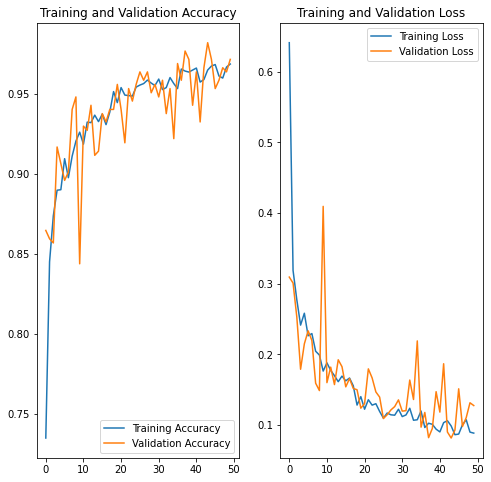

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [30]:
def predict(model, img):
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    score = tf.nn.softmax(predictions[0])
    predicted_class = class_names[np.argmax(score)]
    confidence = round(100 * np.max(score), 2) 
    
    return predicted_class, confidence

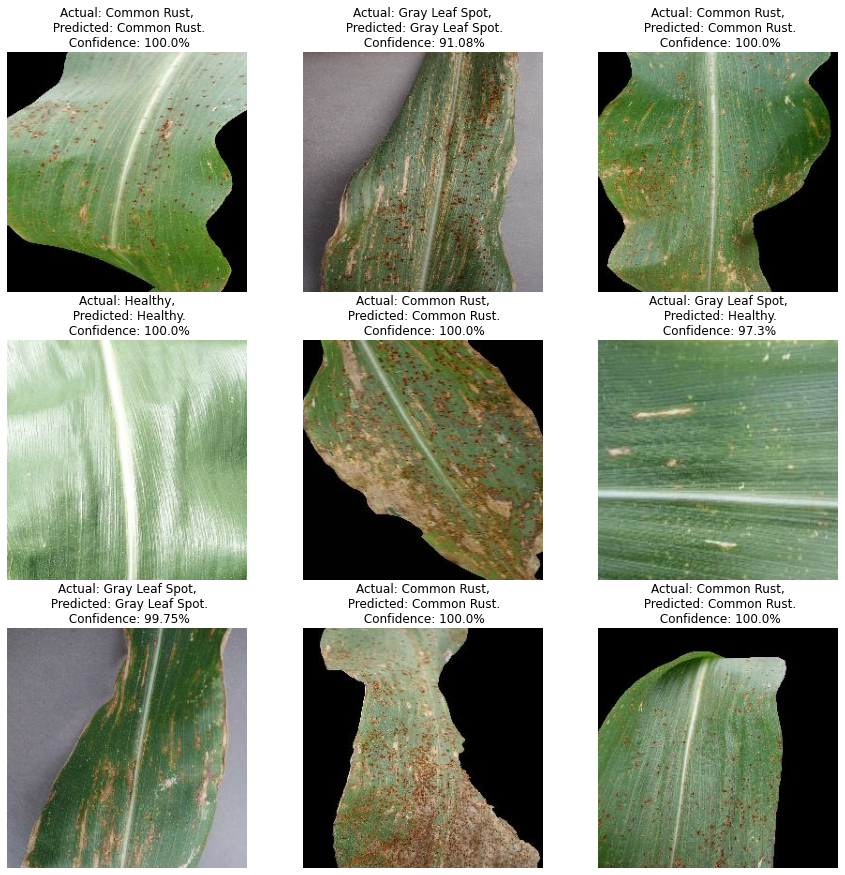

In [31]:
plt.figure(figsize=(15, 15))

for images, labels in test_dataset.take(1):
    
    for i in range(9):
        
        ax = plt.subplot(3, 3, i + 1)
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [32]:
model.save('../model')

INFO:tensorflow:Assets written to: ../model\assets
